# Survive your commuting
In this notebook, we deal with the UK road safety dataset from 1979 to 2015: we plot several relevant features to get an idea of where and when do accidents happens, who is the most common victims etc. To do so, we also visualize accident distribution across the country, without surprise a majority of accidents happens in urban areas.


In [10]:
#import
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
import folium.plugins
from scipy import stats
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans

## Load the data
> First, we define some global variables used to download the dataset. Since we have data across three different periods (1979 - 2004, 2004 - 2014, 2015), we merge all of them into a single dataframe for each category. To do so, we have to make the three datasets compatible with each other: we decided to remove some columns which where not used across all periods and which do not add relevant information for our approach, as of now.  

In [2]:
#Global
DATA_FOLDER = [
               './data/Stats19-Data1979-2004/', 
               './data/Stats19_Data_2005-2014/', 
               './data/RoadSafetyData_2015/']

#columns we want to extract from each file
use_cols = [[#Space and time context
            'Date','Time', 'Longitude', 'Latitude','Day_of_Week',
            #Identifier
            'Accident_Index', 
            #Police force related
            'Police_Force', 'Local_Authority_(District)', 'Local_Authority_(Highway)','Did_Police_Officer_Attend_Scene_of_Accident',
            #Casualties
            'Accident_Severity', 'Number_of_Casualties','Number_of_Vehicles',
            #Road conditions and traffic signalisations
            '1st_Road_Class', '1st_Road_Number', 'Road_Type', 'Speed_limit', 'Junction_Detail', 'Junction_Control',
            '2nd_Road_Class', '2nd_Road_Number',
            #Pedestrian 
            'Pedestrian_Crossing-Human_Control', 'Pedestrian_Crossing-Physical_Facilities', 
            #Visibility and road conditions
            'Light_Conditions', 'Weather_Conditions', 'Road_Surface_Conditions', 'Special_Conditions_at_Site', 'Carriageway_Hazards',
            'Urban_or_Rural_Area', 
            #'Location_Easting_OSGR','Location_Northing_OSGR', 'LSOA_of_Accident_Location',
           ],
    #casualties
    ['Accident_Index', 'Age_Band_of_Casualty',
     #'Age_of_Casualty', 
     'Bus_or_Coach_Passenger', 'Car_Passenger',
     'Casualty_Class', 'Casualty_Home_Area_Type', 
     #'Casualty_IMD_Decile',
     'Casualty_Reference', 'Casualty_Severity', 'Casualty_Type',
     'Pedestrian_Location', 'Pedestrian_Movement',
     'Pedestrian_Road_Maintenance_Worker', 'Sex_of_Casualty',
     'Vehicle_Reference'],
    #vehicules
    ['Accident_Index', '1st_Point_of_Impact',
     'Age_Band_of_Driver', 
     #'Age_of_Driver', 
     'Age_of_Vehicle','Driver_Home_Area_Type', 'Driver_IMD_Decile', 'Engine_Capacity_(CC)',
     'Hit_Object_in_Carriageway', 'Hit_Object_off_Carriageway',
     'Journey_Purpose_of_Driver', 'Junction_Location', 'Propulsion_Code',
     'Sex_of_Driver', 'Skidding_and_Overturning', 'Towing_and_Articulation',
     #'Vehicle_IMD_Decile', 
     'Vehicle_Leaving_Carriageway',
     'Vehicle_Location-Restricted_Lane', 'Vehicle_Manoeuvre',
     'Vehicle_Reference', 'Vehicle_Type', 'Was_Vehicle_Left_Hand_Drive?']
]

#features legends
LEGENDS = pd.read_excel(DATA_FOLDER[0] + 'Road-Accident-Safety-Data-Guide-1979-2004.xls',
                        sheet_name = None,
                       )
#modify legend names to match with df features
for k in [k for k in LEGENDS.keys()]:
    LEGENDS[k.replace(' ', '_')] = LEGENDS.pop(k)


In [3]:
#HELPERS

def plot_distrib(acc, group = "Day_of_Week", colname = 'index', ax = None):
    """
    Plot the distribution of colname per group
    """
    if colname == 'index':
        acc[acc[group] != -1].groupby([group]).count().iloc[:,0].plot.bar(x = group, 
                                                       title = "Accidents distribution per {}".format(group),
                                                       ax = ax)
    else:
        acc[acc[group] != -1].groupby([group])[colname].sum().plot.bar(x = group, 
                                                     title = "{} distribution per {}".format(colname, group),
                                                     ax = ax)                        

        
def categorical_labels(df):
    for col in list(set(LEGENDS.keys() & df.columns)):
        try:
            df[col].replace( list(LEGENDS[col]['code']), LEGENDS[col]['label'], inplace = True)
        except KeyError:
            df[col].replace( list(LEGENDS[col]['Code']), LEGENDS[col]['Label'], inplace = True)
            pass
    
    return df
    


>We decided not to use the oldest data because it has a lot of missing values in addition with being completely outdated. This choice was also motivated by the deprecation of its format: it lacks some features and some feature names have been changed for the two other periods.

In [4]:
#load data
if True:
    df_list = [[] for i in range(3)]
    
    #for every period
    for file in DATA_FOLDER[1:]:
        
        #for every dataset (accidents, casualties, vehicules)
        files = sorted([doc for doc in os.listdir(file) if ".xls" not in doc and doc != '.DS_Store'])
        for doc in files:
            print(doc)
            index = files.index(doc)
            if index == 0:
                df_list[index].append(pd.read_csv(file + doc, 
                                                  index_col= "Accident_Index",
                                                  parse_dates=['Date'],
                                                  dayfirst=True,
                                                  infer_datetime_format=True,
                                                  usecols = use_cols[index],
                                       ))
            else:
                df_list[index].append(pd.read_csv(file + doc,
                                                  usecols = use_cols[index],
                                       ))
    
    accidents = pd.concat(df_list[0], axis = 0, ignore_index = True)

    casualties = pd.concat(df_list[1], axis = 0, ignore_index = True)

    vehicules = pd.concat(df_list[2], axis = 0, ignore_index = True)


years = np.arange(2005, 2016)

accidents.head()

Accidents0514.csv
Casualties0514.csv
Vehicles0514.csv
Accidents_2015.csv


/home/sebastien/venv/nn/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Casualties_2015.csv
Vehicles_2015.csv


,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,Local_Authority_(District),...,2nd_Road_Number,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident
0,-0.191170,51.489096,1,2,1,1,2005-01-04,3,17:42,12,...,0,0,1,1,2,2,0,0,1,1
1,-0.211708,51.520075,1,3,1,1,2005-01-05,4,17:36,12,...,0,0,5,4,1,1,0,0,1,1
2,-0.206458,51.525301,1,3,2,1,2005-01-06,5,00:15,12,...,0,0,0,4,1,1,0,0,1,1
3,-0.173862,51.482442,1,3,1,1,2005-01-07,6,10:35,12,...,0,0,0,1,1,1,0,0,1,1
4,-0.156618,51.495752,1,3,1,1,2005-01-10,2,21:13,12,...,0,0,0,7,1,2,0,0,1,1


In [5]:
accidents.Time = pd.to_datetime(accidents.Time, format='%H:%M')

## Clean the data
> Once the dataset is downloaded, we have to clean it in order to make it usable: to do so we remove the '-1' values which correspond to unknown data or missing values.

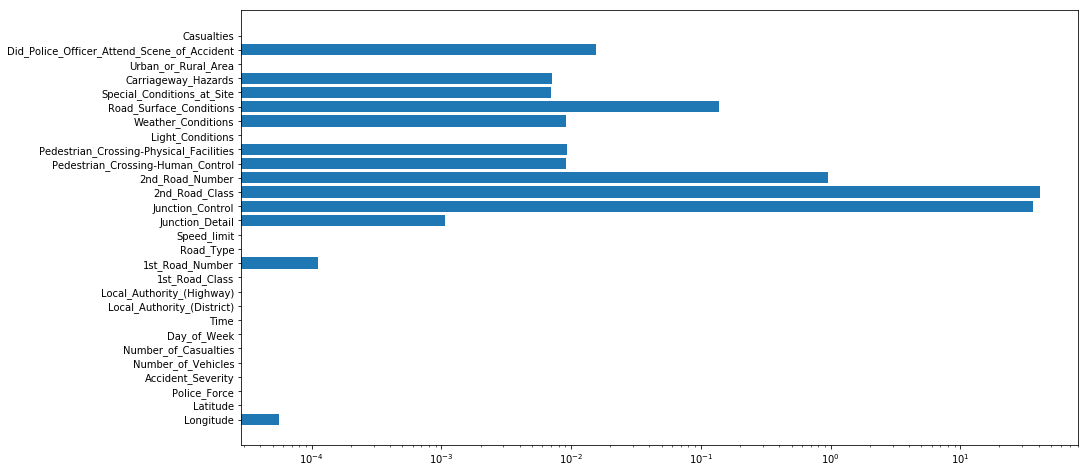

In [5]:
# Cleaning the dataset
percentage_of_nan = {}
columns = [col for col in accidents.columns if not col == 'Date']
for col in columns:
    percentage_of_nan[col] = (accidents[col] == -1 + accidents[col].isnull()).sum() / len(accidents) * 100
x = np.arange(len(percentage_of_nan))
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.barh(x, list(percentage_of_nan.values()), tick_label=list(percentage_of_nan.keys()), log=True);

> This plot show that rows are mostly complete. Some columns are full of missing values but these missing values are still meaningfull: for instance, there is not always a second road if the accident did not take place at an intersection. That's why we keep rows with missing values for some features. On the contrary, columns relevant to the accident's position (Latitude and longitude) have only few missing values which we need to remove to plot the map.

In [6]:
accidents = accidents[accidents.Latitude.notnull() & accidents.Longitude.notnull()]

> We know that the names of the legends do not fit the name of the features, we need to replace whitespace by underscore. Then for each dataframe, we turn its "numerical categorical" values into its categorical value.

In [7]:
#modify legend names to match with df features
for k in [k for k in LEGENDS.keys()]:
    LEGENDS[k.replace(' ', '_')] = LEGENDS.pop(k)

#some exceptions
LEGENDS['Weather_Conditions'] = LEGENDS.pop('Weather')
LEGENDS['Bus_or_Coach_Passenger'] = LEGENDS.pop('Bus_Passenger')
LEGENDS['Casualty_Home_Area_Type'] = LEGENDS.pop('Home_Area_Type')
LEGENDS['Age_Band_of_Casualty'] = LEGENDS.pop('Age_Band')

#let's map numerica categorical data to their label:
accidents = categorical_labels(accidents)
casualties = categorical_labels(casualties)
vehicules = categorical_labels(vehicules)

accidents.head()

,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,Local_Authority_(District),...,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,Casualties
0,-0.191170,51.489096,Metropolitan Police,Serious,1,1,2005-01-04,Tuesday,17:42,Kensington and Chelsea,...,0,1,Daylight,Raining no high winds,2,None,None,1,1,NaN
1,-0.211708,51.520075,Metropolitan Police,Slight,1,1,2005-01-05,Wednesday,17:36,Kensington and Chelsea,...,0,5,Darkness - lights lit,Fine no high winds,1,None,None,1,1,NaN
2,-0.206458,51.525301,Metropolitan Police,Slight,2,1,2005-01-06,Thursday,00:15,Kensington and Chelsea,...,0,0,Darkness - lights lit,Fine no high winds,1,None,None,1,1,NaN
3,-0.173862,51.482442,Metropolitan Police,Slight,1,1,2005-01-07,Friday,10:35,Kensington and Chelsea,...,0,0,Daylight,Fine no high winds,1,None,None,1,1,NaN
4,-0.156618,51.495752,Metropolitan Police,Slight,1,1,2005-01-10,Monday,21:13,Kensington and Chelsea,...,0,0,Darkness - lighting unknown,Fine no high winds,2,None,None,1,1,NaN


In [8]:
LEGENDS.keys()


odict_keys(['Introduction', 'Export_Variables', 'Police_Force', 'Accident_Severity', 'Day_of_Week', 'Local_Authority_(District)', 'Local_Authority_(Highway)', '1st_Road_Class', 'Road_Type', 'Junction_Detail', 'Junction_Control', '2nd_Road_Class', 'Ped_Cross_-_Human', 'Ped_Cross_-_Physical', 'Light_Conditions', 'Road_Surface', 'Special_Conditions_at_Site', 'Carriageway_Hazards', 'Urban_Rural', 'Police_Officer_Attend', 'Vehicle_Type', 'Towing_and_Articulation', 'Vehicle_Manoeuvre', 'Vehicle_Location', 'Junction_Location', 'Skidding_and_Overturning', 'Hit_Object_in_Carriageway', 'Veh_Leaving_Carriageway', 'Hit_Object_Off_Carriageway', '1st_Point_of_Impact', 'Was_Vehicle_Left_Hand_Drive', 'Journey_Purpose', 'Sex_of_Driver', 'Vehicle_Propulsion_Code', 'Casualty_Class', 'Sex_of_Casualty', 'Casualty_Severity', 'Ped_Location', 'Ped_Movement', 'Car_Passenger', 'Ped_Road_Maintenance_Worker', 'Casualty_Type', 'IMD_Decile', 'Weather_Conditions', 'Bus_or_Coach_Passenger', 'Casualty_Home_Area_Type',

## Visualise some of the features
> We want to put things into perspectives: understand the distribution of accidents across time and space.

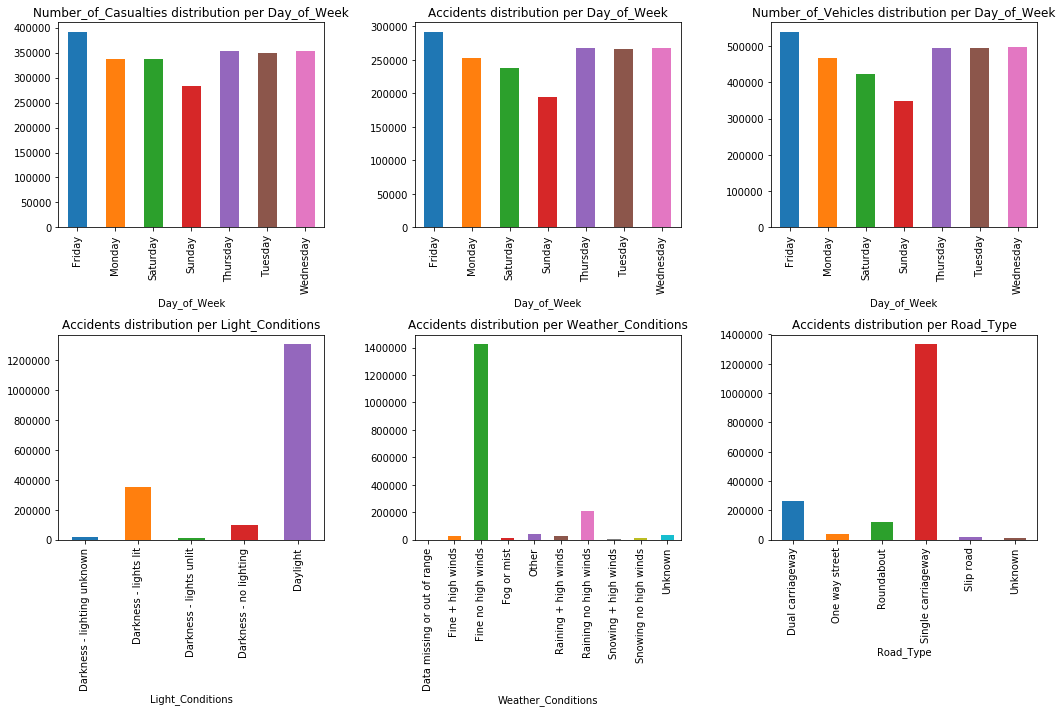

In [9]:
#Weekly distribution, plots using the accidents dataframe
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
plot_distrib(accidents, colname = "Number_of_Casualties", ax = axes[0][0])
plot_distrib(accidents, ax = axes[0][1])
plot_distrib(accidents, colname = "Number_of_Vehicles", ax = axes[0][2])
plot_distrib(accidents, group = "Light_Conditions", ax = axes[1][0])
plot_distrib(accidents, group = "Weather_Conditions", ax = axes[1][1])
plot_distrib(accidents, group ="Road_Type", ax = axes[1][2])
fig.tight_layout()


> *Weekly distribution*: days appear to have the same distribution accross the week except for Sunday and Friday. Actually, Sunday has the lowest figure: one can assume tha people take less frequently their cars on week-ends or that there are less cars on the road because they are full. On the contrary, Friday has the highest number of accident, is it due to the week-end leave after work? We could dig deeper to see if it is equally distributed between morning and afternoon... 
>>What's more there are more wounded people but less vehicles on Sunday compared to Monday. It could be explained by the fact that on Sunday people are traveling with their family: cars are almost full. While, on Monday people are commuting: one person by car.

> *Driving conditions*: We need to have more data to draw any conclusions regarding the light and weather conditions: we can observe that there is more accidents for a particular set of conditions but it is likely to be the most common set (for instance daylight: most people uses their car during the day and sleep at night).


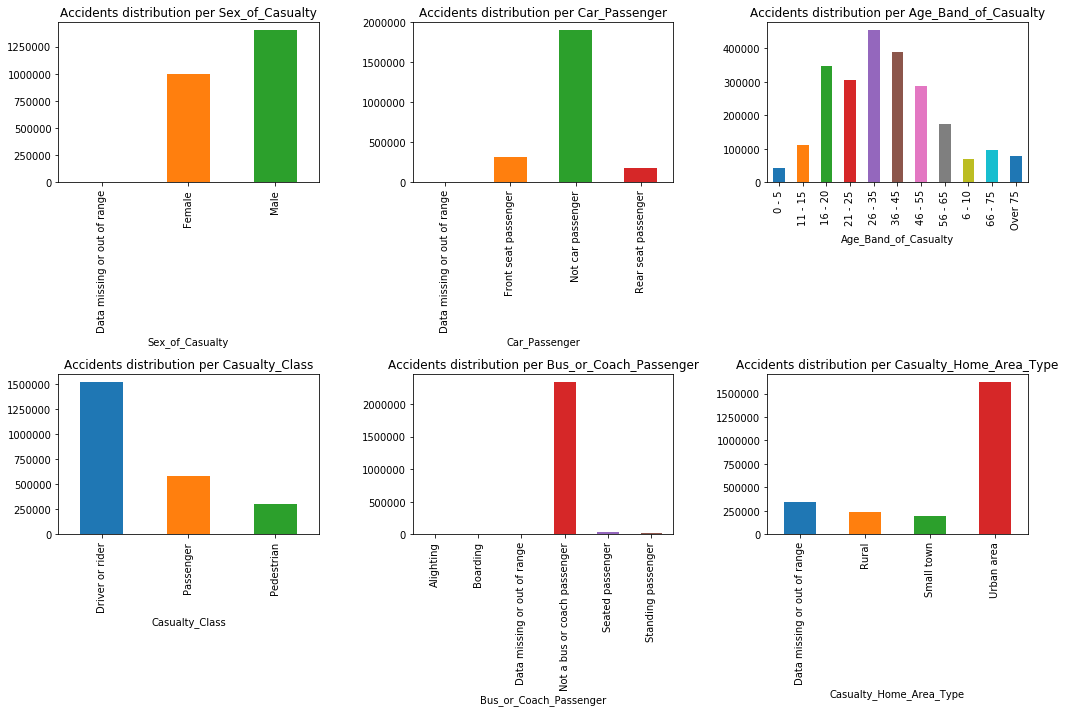

In [10]:
#plot using the casualties dataframe
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
plot_distrib(casualties, group = "Sex_of_Casualty", ax = axes[0][0])
plot_distrib(casualties, group = "Casualty_Class", ax = axes[1][0])
plot_distrib(casualties, group = "Age_Band_of_Casualty", ax = axes[0][2])
plot_distrib(casualties, group = "Car_Passenger", ax = axes[0][1])
plot_distrib(casualties, group = "Bus_or_Coach_Passenger", ax = axes[1][1])
plot_distrib(casualties, group = "Casualty_Home_Area_Type", ax = axes[1][2])
fig.tight_layout()


>Without suprise, we observe that there are more men than women amopng casualties: statistically speaking men have more car accidents than women. Similarly, the majority of the casualties is among adult (from 20 to 60), people who have more chance to be one the road either as a driver, a passenger or a pedestrian.

> The graph about the bus or coach passenger shows that most casualties are not on a bus. One can assume that bus are less involved in road accidents and therefore make less casualties.

> Most casualties live in urban areas, why is that? The map below might explain this figure.

## Map visualization

In [7]:
# Plot every accidents in the UK from 2005 to 2014
london_coord = [55.3780518, -3.4359729]
m = folium.Map(location=london_coord, zoom_start=5)
marker_cluster = folium.plugins.marker_cluster.MarkerCluster().add_to(m)
for acc in accidents.sample(2000).itertuples():
    folium.Marker([acc.Latitude, acc.Longitude]).add_to(marker_cluster)
m.save("bubles.html")

In [8]:
# Plot the approximate density of accidents in the UK
m = folium.Map(location=london_coord, zoom_start=5)
folium.plugins.HeatMap(accidents[['Latitude', 'Longitude', 'Number_of_Casualties']].sample(2000).values).add_to(m)
m.save("density.html")

In [9]:
acc_per_year_and_month = accidents[['Latitude', 'Longitude', 'Number_of_Casualties']].groupby([accidents.Date.dt.year, accidents.Date.dt.month])
times = list(map(lambda i: datetime.datetime(i[0], i[1], 1).strftime('%b %Y'), acc_per_year_and_month.indices))
# Plot the approximate density of accidents in the UK year per year
m = folium.Map(location=london_coord, zoom_start=5)
folium.plugins.HeatMapWithTime([acc_per_year_and_month.get_group(gr).sample(2000).values.tolist()
                                for gr in acc_per_year_and_month.indices], index=times).add_to(m)
m.save("density_by_year.html")

> We saved the results of the maps as html files to look at separetely. Those are very interesting when we look at an important zoom level. When too zoomed out, we don't see very much what is happening. 

## Historic analysis
Since data is available for different periods, we would like to understand how it has evolve for the last 10 years.

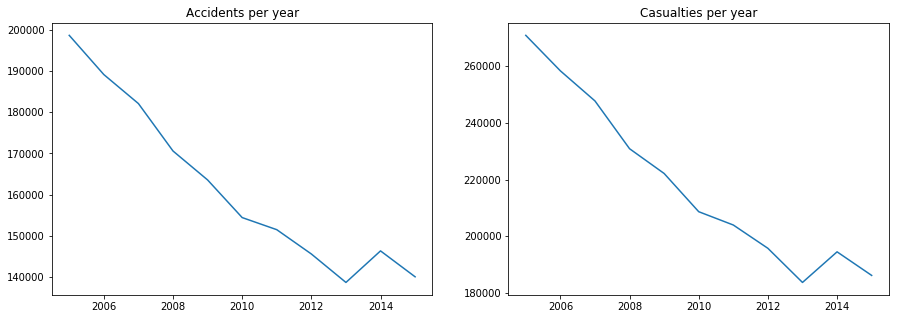

In [14]:
# Plot casualties per year: we expect a decrease
accidents_per_year = accidents.groupby([accidents.Date.dt.year, accidents.Urban_or_Rural_Area])\
    .count()['Longitude']
casualties_per_year = accidents.groupby([accidents.Date.dt.year, accidents.Urban_or_Rural_Area])\
    .agg({'Number_of_Casualties': 'sum'})
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(years, accidents_per_year.groupby('Date').sum().values)
ax1.set_title("Accidents per year")
ax2.plot(years, casualties_per_year.groupby('Date').sum().values)
ax2.set_title("Casualties per year");

> We see that there is a sharp decrease in the number of accidents and casualties since 2005. Since the slope is almost linear, this seems to be a general trend and the policies applied during this period doesn't seem to have an important effect on it. However, there is a bump in 2014 that seem worth working on.

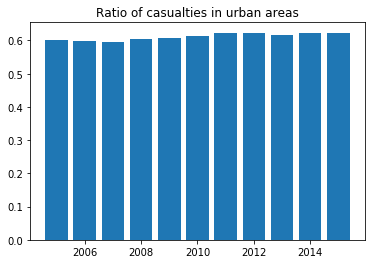

In [16]:
# Plot the ratio of casualties in urban areas
plt.bar(years, [casualties_per_year.loc[y, 1][0] / (casualties_per_year.loc[y, 1][0] + casualties_per_year.loc[y, 2][0]) for y in years])
plt.title("Ratio of casualties in urban areas");

> The ratio of casualities in urban area doesn't change very much from year to year and seems to be quite stable. So it doesn't seem to be a very interesting metric to look at across the years.

In [78]:
# Printing correlation coefficients between different metrics
print(np.corrcoef(accidents['Number_of_Casualties'], accidents['Urban_or_Rural_Area'])[0][1])

0.11578099277438217


In [79]:
print(np.corrcoef(accidents['Number_of_Casualties'], accidents['Day_of_Week'])[0][1])

-0.0009398510805306531


In [80]:
print(np.corrcoef(accidents['Number_of_Casualties'], accidents['Weather_Conditions'])[0][1])

-0.004545776171593734


In [81]:
print(np.corrcoef(accidents['Number_of_Casualties'], accidents['Light_Conditions'])[0][1])

0.03673591371686548


In [ ]:
print(np.corrcoef(accidents['Number_of_Casualties'], accidents['1st_Road_Class'])[0][1])

> After a first look at the correlation coefficient, we should deepen our analysis to understand why some factors seem to be much more important than others for instance why is the area more important than the weather ? Besides, most people believe that weather conditions and accidents likelihodd are strongly connected. Can we explain such beliefs with our dataset ?

dict_values([Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            198590, 198592, 198593, 198594, 198595, 198596, 198597, 198598,
            198599, 198606],
           dtype='int64', length=16275), Int64Index([    28,     29,     30,     31,     32,     33,     34,     35,
                36,     37,
            ...
            198415, 198416, 198417, 198418, 198591, 198600, 198601, 198602,
            198603, 198604],
           dtype='int64', length=14520), Int64Index([    67,     78,     79,     81,     84,     85,     86,     87,
                88,     89,
            ...
            198435, 198436, 198446, 198605, 198607, 198608, 198609, 198610,
            198611, 198615],
           dtype='int64', length=14973), Int64Index([   134,    135,    136,    139,    141,    142,    143,    144,
               145,    146,
            ...
            198617, 198618, 198619, 198620, 198621, 198622, 198623, 1

In [ ]:
# Let's try to predict the number of casualties with the condition of the accident
X = accidents[[#Space and time context
    'Number_of_Casualties',
            'Time', 'Longitude', 'Latitude', 'Day_of_Week',
            'Number_of_Vehicles',
            #Visibility and road conditions
            'Light_Conditions', 'Weather_Conditions', 'Road_Surface_Conditions', 'Special_Conditions_at_Site', 'Carriageway_Hazards',
            'Urban_or_Rural_Area'
           ]]
X.Time = X.Time.dt.hour
X.dropna(axis=0, inplace=True)
y = X['Number_of_Casualties']
X.drop('Number_of_Casualties', axis=1, inplace=True)
clf = LogisticRegression()
cross_val_score(clf, X.values, y.values, cv=3)

/home/sebastien/venv/nn/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/home/sebastien/venv/nn/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/sebastien/venv/nn/lib/python3.6/site-packages/sklearn/model_selection/_split.py:626: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
/home/sebastien/venv/nn/lib/python3.6/site-packages/s

In [89]:
accidents.Time.dt.hour

0          17.0
1          17.0
2           0.0
3          10.0
4          21.0
5          12.0
6          20.0
7          17.0
8          22.0
9          16.0
10          0.0
11         20.0
12         12.0
13          5.0
14         11.0
15         10.0
16          0.0
17          9.0
18         21.0
19          3.0
20         21.0
21         17.0
22         21.0
23         17.0
24          7.0
25         16.0
26         20.0
27         13.0
28         18.0
29          7.0
           ... 
1780623    17.0
1780624    19.0
1780625     1.0
1780626    19.0
1780627    14.0
1780628     8.0
1780629     6.0
1780630    11.0
1780631     4.0
1780632    15.0
1780633    13.0
1780634    15.0
1780635     6.0
1780636    14.0
1780637     9.0
1780638    14.0
1780639    22.0
1780640    20.0
1780641     9.0
1780642    19.0
1780643    16.0
1780644    20.0
1780645    17.0
1780646    16.0
1780647     2.0
1780648    13.0
1780649    13.0
1780650     0.0
1780651    12.0
1780652    16.0
Name: Time, Length: 1780

In [109]:
X.dropna(axis=0)

,Time,Longitude,Latitude,Day_of_Week,Number_of_Vehicles,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area
0,17.0,-0.191170,51.489096,3,1,1,2,2,0,0,1
1,17.0,-0.211708,51.520075,4,1,4,1,1,0,0,1
2,0.0,-0.206458,51.525301,5,2,4,1,1,0,0,1
3,10.0,-0.173862,51.482442,6,1,1,1,1,0,0,1
4,21.0,-0.156618,51.495752,2,1,7,1,2,0,0,1
5,12.0,-0.203238,51.515540,3,2,1,2,2,6,0,1
6,20.0,-0.211277,51.512695,5,2,4,1,1,0,0,1
7,17.0,-0.187623,51.502260,6,1,1,1,1,0,0,1
8,22.0,-0.167342,51.483420,7,2,4,1,1,0,0,1
9,16.0,-0.206531,51.512443,7,2,1,1,1,0,0,1


In [19]:
def to_bins(data, n_bins):
    width = (data.max() - data.min()) / n_bins
    return data.map(lambda x: np.ceil(x / width) * width)

accidents['Latitude_bin'] = to_bins(accidents.Latitude, 10000)
accidents['Longitude_bin'] = to_bins(accidents.Longitude, 10000)
acc_per_latlng = accidents.groupby(['Latitude_bin', 'Longitude_bin'])

> We grouped the accidents per location in order to see the most dangerous ones

In [35]:
# Get the index of the place with the most casualties
acc_per_latlng.agg({'Number_of_Casualties': 'sum'}).sort_values('Number_of_Casualties', ascending=False).iloc[0]

Number_of_Casualties    244
Name: (51.57150956649999, -0.09556582050000001), dtype: int64

In [37]:
acc_at_loc = acc_per_latlng.get_group((51.57150956649999, -0.09556582050000001))
m = folium.Map(location=london_coord, zoom_start=5)
marker_cluster = folium.plugins.marker_cluster.MarkerCluster().add_to(m)
for acc in acc_at_loc.itertuples():
    folium.Marker([acc.Latitude, acc.Longitude]).add_to(marker_cluster)
m

In [38]:
acc_at_loc

,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,Local_Authority_(District),...,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,Latitude_bin,Longitude_bin
4723,-0.096159,51.570594,1,3,1,1,2005-02-04,6,1900-01-01 11:10:00,4,...,5,1,1,1,0,0,1,1,51.57151,-0.095566
4744,-0.096011,51.570682,1,3,2,1,2005-02-27,1,1900-01-01 16:19:00,4,...,5,1,1,1,0,0,1,1,51.57151,-0.095566
4752,-0.096007,51.570772,1,3,2,1,2005-02-14,2,1900-01-01 18:49:00,4,...,0,4,1,1,0,0,1,1,51.57151,-0.095566
4787,-0.096018,51.570502,1,3,2,1,2005-03-11,6,1900-01-01 01:02:00,4,...,5,4,1,1,0,0,1,1,51.57151,-0.095566
4796,-0.096018,51.570502,1,3,2,1,2005-03-17,5,1900-01-01 04:32:00,4,...,5,4,1,1,0,0,1,1,51.57151,-0.095566
4811,-0.096018,51.570502,1,3,2,1,2005-03-26,7,1900-01-01 13:13:00,4,...,5,1,1,1,0,0,1,1,51.57151,-0.095566
4812,-0.096011,51.570682,1,3,2,1,2005-03-28,2,1900-01-01 22:30:00,4,...,5,4,1,1,0,0,1,1,51.57151,-0.095566
4827,-0.095870,51.570589,1,3,2,1,2005-04-07,5,1900-01-01 00:01:00,4,...,5,4,2,2,0,0,1,1,51.57151,-0.095566
4834,-0.095730,51.570497,1,3,1,1,2005-04-11,2,1900-01-01 16:15:00,4,...,0,1,1,1,0,0,1,1,51.57151,-0.095566
4881,-0.096155,51.570684,1,3,2,1,2005-04-25,2,1900-01-01 21:20:00,4,...,5,4,2,2,0,0,1,1,51.57151,-0.095566
